# Collaborative structural biology using machine learning and Jupyter notebook
##    Fergus Boyles and Fergus Imrie
##    *Department of Statistics, University of Oxford*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
#%matplotlib inline
%run halp.py

_Load and look:_ Can directly load data from csv using pandas. Don't forget to look at your data!

Should explain what our dataset is, and probably what the features are.

In [2]:
data = pd.read_csv('../data/Data_3DSig.txt', sep=' ')
data.dropna(axis='index', how='any', inplace=True)
data.head()

,Target,Template,Target_Length,Template_Length,Contact_PPV,Contact_TP,Contact_P,Contact_All,Neff,SeqID,Label
0,d12asa_,d1yfsa2,328,237,4.65,2,43,101,2676,0.177,Fam
1,d12asa_,d1eova2,328,354,22.99,20,87,101,2676,0.223,Fam
2,d12asa_,d1b8aa2,328,336,22.22,20,90,101,2676,0.220,Fam
3,d12asa_,d1l0wa3,328,357,20.00,17,85,101,2676,0.235,Fam
4,d12asa_,d1z7ma1,328,312,1.27,1,79,101,2676,0.211,Fam


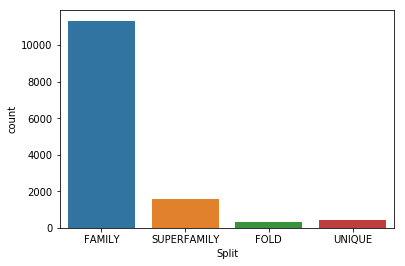

In [3]:
split = pd.read_csv('../data/Data_Split.txt', sep=' ', header=None)
split.columns = ['Protein', 'Split']
sns.countplot(data=split, x='Split')

# Classification a la Saulo

TODO write a little about how the data set is structured and what features are computed.

The data set is split into four disjoint clusters. 

1 - proteins that are in the same family as at least one other protein
2 - proteins that are not in the same family, but are in the same superfamily as at least one other protein
3 - proteins that are not in the same superfamily, but share the same fold as at least one other protein
4 - proteins that do not belong to the same fold as any other protein in the data set

Most proteins fall into the first cluster, so we're going to use this portion of the data for the rest of this notebook. Note that although each protein in this cluster is in the same family as at least one other protein, there are many different families that are collected into superfamilies, and these superfamilies are further collected into folds.

In [4]:
family_targets = split[split['Split']=='FAMILY']['Protein']
family_data = data[(data['Target'].isin(family_targets)) & (data['Template'].isin(family_targets))].copy()

# The 'easy' problem: 'same family' vs 'random' classification

Can we predict, given the features, whether the target and template protein are from the same protein family?

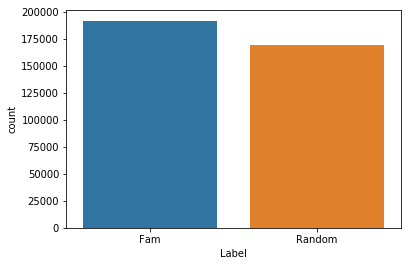

In [5]:
sns.countplot(data=family_data[family_data['Label'].isin(['Fam', 'Random'])], x='Label')

Data is balanced so don't need to worry about any imbalance.

Important that we decide train/validation/test sets before we go any further. We adopt a 80/10/10 split. Note below that we sample a subset (5000) of the total number of proteins (10251). Also note that we're splitting *by target* rather than simply splitting the examples. This ensures that all examples for a target are in the same set.

Also, for reproducibility, we set the seed for our random number generator.

In [6]:
family_data.loc[:,'Family'] = pd.get_dummies(family_data[['Label']]).loc[:, 'Label_Fam']

/home/fergus/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


,Target,Template,Target_Length,Template_Length,Contact_PPV,Contact_TP,Contact_P,Contact_All,Neff,SeqID,Label,Family
0,d12asa_,d1yfsa2,328,237,4.65,2,43,101,2676,0.177,Fam,1
1,d12asa_,d1eova2,328,354,22.99,20,87,101,2676,0.223,Fam,1
2,d12asa_,d1b8aa2,328,336,22.22,20,90,101,2676,0.220,Fam,1
3,d12asa_,d1l0wa3,328,357,20.00,17,85,101,2676,0.235,Fam,1
4,d12asa_,d1z7ma1,328,312,1.27,1,79,101,2676,0.211,Fam,1


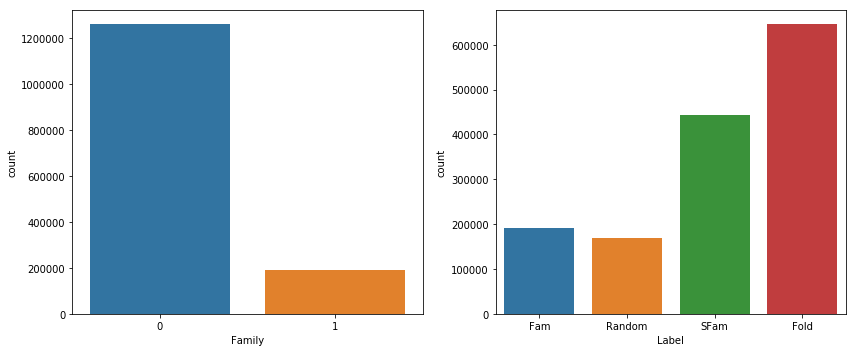

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(data=family_data, x='Family',ax=ax1)
sns.countplot(data=family_data, x='Label', ax=ax2)
fig.tight_layout()
fig.show()
family_data.head()

In [8]:
pairs = [(target, template) for target, template in zip(family_data['Target'].values, family_data['Template'].values)]
print(len(pairs) - len(list(set(pairs))))

5690


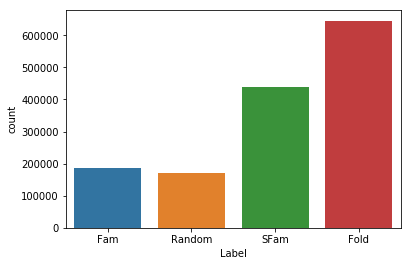

In [9]:
# duplicate target-template pairs, wat do?
df = family_data.drop_duplicates(subset=['Template', 'Target'], keep=False, inplace=False)
sns.countplot(data=df, x='Label')

In [10]:
X = df[df['Label'].isin(['Fam', 'Random'])]

In [11]:
# Randomly select a subset of targets to play with

np.random.seed(42)
n_samples = 10000
sample = np.random.choice(X['Target'].unique(), size=n_samples, replace=False)
n_train = int(0.8*n_samples)
n_valid = int(0.1*n_samples)
train = sample[:n_train]
validation = sample[n_train:n_train+n_valid]
test = sample[n_train+n_valid:]

In [12]:
feature_names = ['Target_Length', 'Template_Length', 'Contact_PPV', 'Contact_TP', 'Contact_P', 'Contact_All', 'Neff', 'SeqID']

In [13]:
X_train = X[X['Target'].isin(train)][feature_names]
X_validation = X[X['Target'].isin(validation)][feature_names]
X_test = X[X['Target'].isin(test)][feature_names]

y_train = X[X['Target'].isin(train)]['Label'].replace({'Random': 0, 'Fam': 1})
y_validation = X[X['Target'].isin(validation)]['Label'].replace({'Random': 0, 'Fam': 1})
y_test = X[X['Target'].isin(test)]['Label'].replace({'Random': 0, 'Fam': 1})

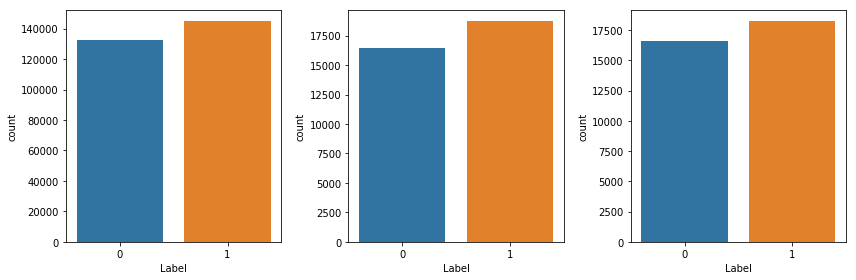

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.countplot(x=y_train, ax=axes[0])
sns.countplot(x=y_validation, ax=axes[1])
sns.countplot(x=y_test, ax=axes[2])
fig.tight_layout()

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate

groups = X[X['Target'].isin(train)]['Target'].values

In [16]:
folds = GroupKFold(n_splits=3).split(X_train, y_train, groups)
clf = LogisticRegression()
scores = cross_validate(clf, X_train.values, y_train.values.ravel(), scoring='roc_auc', cv=folds, return_train_score=False, n_jobs=-1)

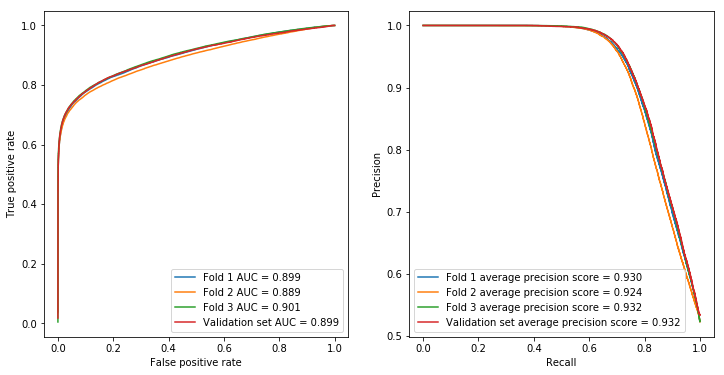

In [17]:
fig, (roc, pr) = plt.subplots(1, 2, figsize=(12, 6))

folds = GroupKFold(n_splits=3).split(X_train, y_train, groups)

clf = LogisticRegression(C=1e5, random_state=42)

for n, (i, j) in enumerate(folds):
    probas = clf.fit(X_train.values[i], y_train.values.ravel()[i]).predict_proba(X_train.values[j])
    draw_roc_curve(y_train.values.ravel()[j], probas[:,1], ax=roc, name=f'Fold {n+1}')
    draw_pr_curve(y_train.values.ravel()[j], probas[:,1], ax=pr, name=f'Fold {n+1}')
    
clf = LogisticRegression(C=1e5, random_state=42)
clf.fit(X_train.values, y_train.values.ravel())
probas = clf.predict_proba(X_validation.values)

draw_roc_curve(y_validation.values.ravel(), probas[:,1], ax=roc, name=f'Validation set')
draw_pr_curve(y_validation.values.ravel(), probas[:,1], ax=pr, name=f'Validation set')

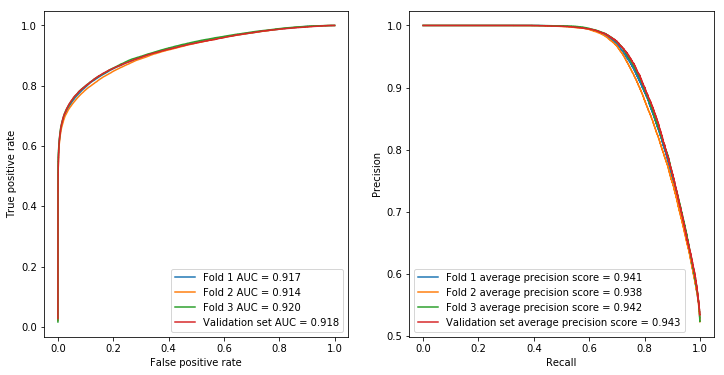

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

logistic = LogisticRegression(C=1e5, random_state=42)
scaler = MinMaxScaler()
clf = Pipeline(steps=[('scaler', scaler), ('logistic', logistic)])

fig, (roc, pr) = plt.subplots(1, 2, figsize=(12, 6))

folds = GroupKFold(n_splits=3).split(X_train, y_train, groups)

for n, (i, j) in enumerate(folds):
    probas = clf.fit(X_train.values[i], y_train.values.ravel()[i]).predict_proba(X_train.values[j])
    draw_roc_curve(y_train.values.ravel()[j], probas[:,1], ax=roc, name=f'Fold {n+1}')
    draw_pr_curve(y_train.values.ravel()[j], probas[:,1], ax=pr, name=f'Fold {n+1}')
    
clf.fit(X_train.values, y_train.values.ravel())
probas = clf.predict_proba(X_validation.values)

draw_roc_curve(y_validation.values.ravel(), probas[:,1], ax=roc, name=f'Validation set')
draw_pr_curve(y_validation.values.ravel(), probas[:,1], ax=pr, name=f'Validation set')

# Chaining scaling with PCA and logistic regression

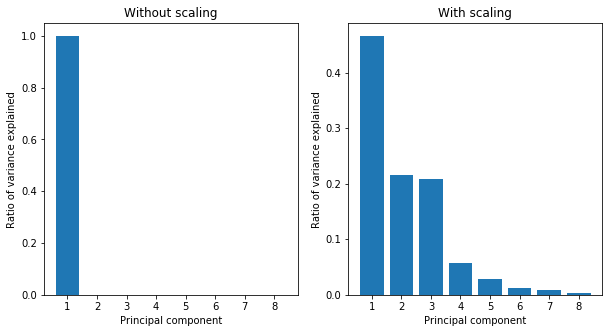

In [19]:
from sklearn.decomposition import PCA

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].bar(np.arange(1, 9), PCA().fit(X_train).explained_variance_ratio_)
axes[0].set_xlabel('Principal component')
axes[0].set_ylabel('Ratio of variance explained')
axes[0].set_title('Without scaling')
axes[0].set_xticks(np.arange(1, 9))

axes[1].bar(np.arange(1, 9), PCA().fit(MinMaxScaler().fit_transform(X_train)).explained_variance_ratio_)
axes[1].set_xlabel('Principal component')
axes[1].set_ylabel('Ratio of variance explained')
axes[1].set_title('With scaling')
axes[1].set_xticks(np.arange(1, 9));

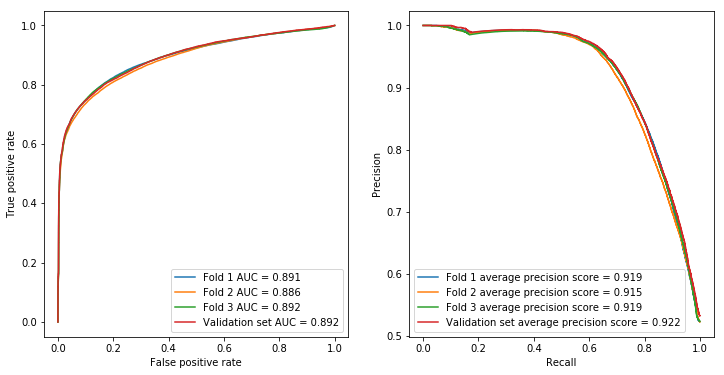

In [20]:
scaler = MinMaxScaler()
pca = PCA(n_components=3)
logistic = LogisticRegression(C=1e5, random_state=42)

clf = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic', logistic)])

fig, (roc, pr) = plt.subplots(1, 2, figsize=(12, 6))

folds = GroupKFold(n_splits=3).split(X_train, y_train, groups)

for n, (i, j) in enumerate(folds):
    probas = clf.fit(X_train.values[i], y_train.values.ravel()[i]).predict_proba(X_train.values[j])
    draw_roc_curve(y_train.values.ravel()[j], probas[:,1], ax=roc, name=f'Fold {n+1}')
    draw_pr_curve(y_train.values.ravel()[j], probas[:,1], ax=pr, name=f'Fold {n+1}')
    
clf.fit(X_train.values, y_train.values.ravel())
probas = clf.predict_proba(X_validation.values)

draw_roc_curve(y_validation.values.ravel(), probas[:,1], ax=roc, name=f'Validation set')
draw_pr_curve(y_validation.values.ravel(), probas[:,1], ax=pr, name=f'Validation set')

In [21]:
# Randomly select a subset of targets to play with

np.random.seed(42)
n_samples = 10000
sample = np.random.choice(X['Target'].unique(), size=n_samples, replace=False)
n_train = int(0.8*n_samples)
n_valid = int(0.1*n_samples)
train = sample[:n_train]
validation = sample[n_train:n_train+n_valid]
test = sample[n_train+n_valid:]

# Dealing with class imbalance - undersampling

Unlike the previous situation where there were almost equal numbers of examples of 'same family' and 'random' target-template pairs, examples of 'same superfamily' and 'same fold' pairs are overrepresented in the data. This sort of class imbalance has repurcussions for both training and testing our models. Imbalanced training data can result in a classifier that is biased toward the majority class if the training rewards or penalises all correct/incorrect predictions equally. Imbalanced test data forces us to reconsider the metrics we use to assess the performance of our classifier; for example, true and false positive rate (and any derived metrics, such as ROC AUC) do not distinguish between different classes. This can lead to a classifier that is biased toward predicting the majority class achieving a very high score despite being poor at actually identifying members of a minority class.

In [22]:
# Make a copy of the training data since we're going to modify it by undersampling 
X_train = df[df['Target'].isin(train)].copy()
X_validation = df[df['Target'].isin(validation)].copy()
X_test = df[df['Target'].isin(test)].copy()

X_train['Label'].value_counts()

Fold      502600
SFam      340130
Fam       145075
Random    132455
Name: Label, dtype: int64

In [23]:
# Undersample Fam, SFam, and Fold data since they are overrepresented and could bias the classifier during training
# Be sure to seed the RNG beforehand so that our undersampling is reproducible
np.random.seed(42)
data_counts = X_train['Label'].value_counts()

for label in ['Fam', 'SFam', 'Fold']:
    idx = X_train[X_train['Label'] == label].index.values
    n_to_drop = data_counts[label] - data_counts['Random']
    to_drop = np.random.choice(idx, size=n_to_drop, replace=False)
    X_train.drop(to_drop, axis='index', inplace=True)
    
groups = X_train['Target'].values

y_train = X_train['Label'].replace({'Random': 0, 'Fam': 1, 'SFam': 2, 'Fold': 3})
y_validation = X_validation['Label'].replace({'Random': 0, 'Fam': 1, 'SFam': 2, 'Fold': 3})
y_test = X_test['Label'].replace({'Random': 0, 'Fam': 1, 'SFam': 2, 'Fold': 3})

X_train = X_train[feature_names]
X_validation = X_validation[feature_names]
X_test = X_test[feature_names]

y_train.value_counts()

3    132455
2    132455
1    132455
0    132455
Name: Label, dtype: int64

# Grouped 3-fold cross validation

As before, we'll split our training data into three equally-sized folds in such a way that the same protein target is not found in more than one fold.

In [24]:
clf = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic', logistic)])

folds = GroupKFold(n_splits=3).split(X_train, y_train, groups)

fold_prediction = [[], [], []]
fold_true = [[], [], []]

for n, (i, j) in enumerate(folds):
    fold_prediction[n] = clf.fit(X_train.values[i], y_train.values.ravel()[i]).predict(X_train.values[j])
    fold_true[n] = y_train.values[j]

# Assessing a multi-class classifier: the confusion matrix

/home/fergus/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


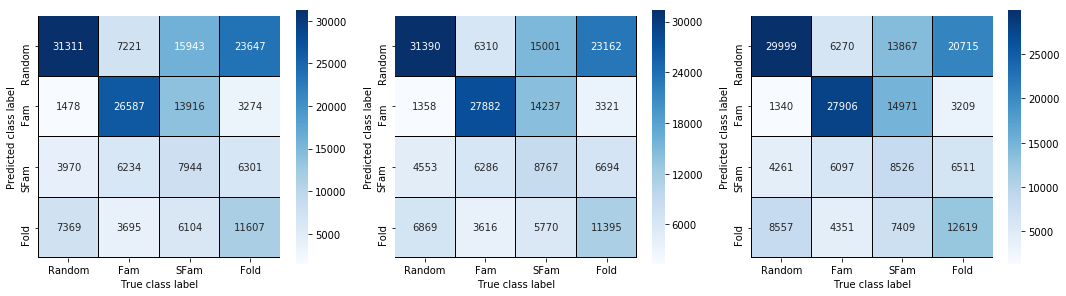

In [25]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for n in range(3):

    cm = pd.DataFrame(confusion_matrix(fold_true[n], fold_prediction[n])).T
    cm.rename({0: 'Random', 1: 'Fam', 2: 'SFam', 3: 'Fold'}, axis='index', inplace=True)
    cm.rename({0: 'Random', 1: 'Fam', 2: 'SFam', 3: 'Fold'}, axis='columns', inplace=True)

    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True, linewidths=0.1, linecolor='k', cbar_kws={'shrink': 0.75}, ax=axes[n])
    axes[n].set_ylabel('Predicted class label')
    axes[n].set_xlabel('True class label')

fig.tight_layout()
fig.show()

/home/fergus/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


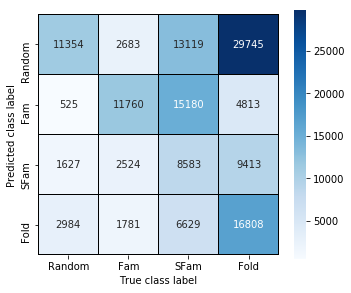

In [26]:
clf = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic', logistic)])
clf.fit(X_train.values, y_train.values.ravel())

pred = clf.predict(X_validation.values)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

cm = pd.DataFrame(confusion_matrix(y_validation.values, pred)).T
cm.rename({0: 'Random', 1: 'Fam', 2: 'SFam', 3: 'Fold'}, axis='index', inplace=True)
cm.rename({0: 'Random', 1: 'Fam', 2: 'SFam', 3: 'Fold'}, axis='columns', inplace=True)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True, linewidths=0.1, linecolor='k', cbar_kws={'shrink': 0.75}, ax=ax)
ax.set_ylabel('Predicted class label')
ax.set_xlabel('True class label')

fig.tight_layout()
fig.show()

# Other classification algorithms: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

Prediction time!

In [11]:
y_pred = rf.predict(X_test)
y_score_oob = [p[1] for p in rf.oob_decision_function_]
y_pred_oob = [round(p) for p in y_score_oob]
y_score_test = [p[1] for p in rf.predict_proba(X_test)]
y_pred_validation = rf.predict(X_validation)
y_score_validation = [p[1] for p in rf.predict_proba(X_validation)]

How to asssess your performance on a classification task? Many possible answers and certainly not a single correct one. Here we consider ROC and precision-recall curves. Given not much class imbalance, curves tell similar stories, but not always the case.

Note OOB performance. Do we expect this? Why might this be the case?

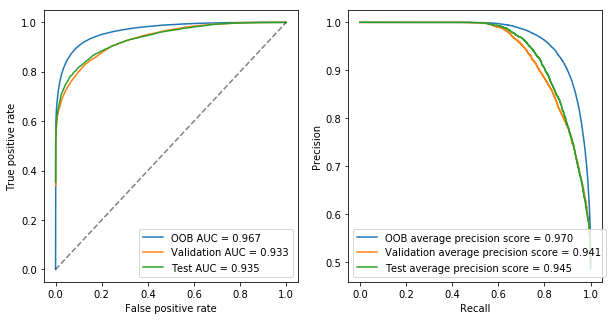

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

draw_roc_curve(y_train, y_score_oob, name='OOB', ax=ax1)
draw_roc_curve(y_validation, y_score_validation, name='Validation', ax=ax1)
draw_roc_curve(y_test, y_score_test, name='Test', ax=ax1)

draw_pr_curve(y_train, y_score_oob, name='OOB', ax=ax2)
draw_pr_curve(y_validation, y_score_validation, name='Validation', ax=ax2)
draw_pr_curve(y_test, y_score_test, name='Test', ax=ax2)

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.legend(loc='best')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc='best')

__Confusion matrix:__ Different way to visualise performance of our classifier. We see there aren't many false positives (bottom right) but quite a few false negatives (top right).

0.86047109648220532

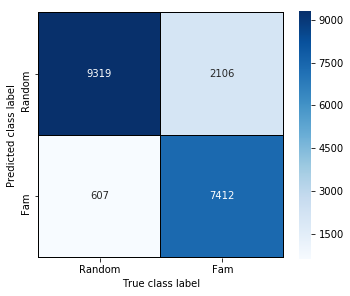

In [13]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, y_pred)).T
cm.rename({0: 'Random', 1: 'Fam'}, axis='index', inplace=True)
cm.rename({0: 'Random', 1: 'Fam'}, axis='columns', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True, linewidths=0.1, linecolor='k', cbar_kws={'shrink': 0.75}, ax=ax)
ax.set_ylabel('Predicted class label')
ax.set_xlabel('True class label')
fig.tight_layout()
rf.score(X_test, y_test)

# Apprentice-tier classification: superfamily vs. random

Now we move onto the problem of classifying whether a target and template are in the same superfamily.

/homes/imrie/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


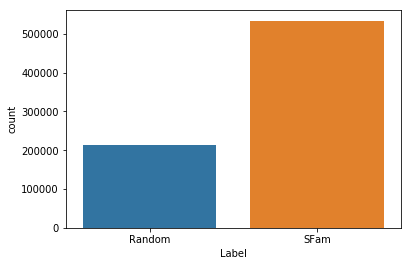

In [14]:
superfamily_data = data[data['Target'].isin(superfamily_targets) & data['Label'].isin(['SFam', 'Random'])]
sns.countplot(data=superfamily_data, x='Label')

You can see we have rougly the same number of negative examples, but many more positive examples. 

Class imbalance is a huge issue when training clasifiers. We choose to undersample superfamily data so that we have an even number of random and superfamily datapoints. 

In [15]:
# Undersample 'SFam' data

sfam_data_counts = superfamily_data['Label'].value_counts()

In [16]:
sfam_data_counts = superfamily_data['Label'].value_counts()
sfam_idx = superfamily_data[superfamily_data['Label'] == 'SFam'].index.values
np.random.seed(42)
n_to_drop = max(sfam_data_counts.values) - min(sfam_data_counts.values) # Prefer this implementation
to_drop = np.random.choice(sfam_idx, size=n_to_drop, replace=False)
superfamily_data.drop(to_drop, axis='index', inplace=True)

/homes/imrie/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


/homes/imrie/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


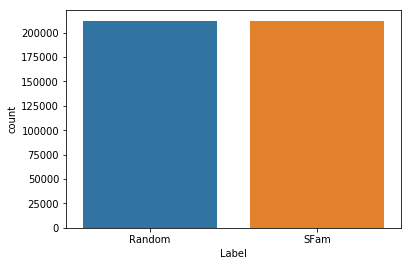

In [17]:
sns.countplot(data=superfamily_data, x='Label')

Same as before: (i) split data, (ii) train classifier, (iii) test predictions.

In [18]:
np.random.seed(42)
n_samples = 5000
sample = np.random.choice(superfamily_targets, size=n_samples, replace=False)
n_train = int(0.8*n_samples)
n_valid = int(0.1*n_samples)
train = sample[:n_train]
validation = sample[n_train:n_train+n_valid]
test = sample[n_train+n_valid:]

In [19]:
superfamily_data[superfamily_data['Target'].isin(train)].shape, superfamily_data[superfamily_data['Target'].isin(validation)].shape, superfamily_data[superfamily_data['Target'].isin(test)].shape

((158215, 11), (20456, 11), (19313, 11))

In [20]:
X_train = superfamily_data[superfamily_data['Target'].isin(train)][feature_names].values
X_validation = superfamily_data[superfamily_data['Target'].isin(validation)][feature_names].values
X_test = superfamily_data[superfamily_data['Target'].isin(test)][feature_names].values

y_train = superfamily_data[superfamily_data['Target'].isin(train)]['Label'].replace({'Random': 0, 'SFam': 1}).values.ravel()
y_validation = superfamily_data[superfamily_data['Target'].isin(validation)]['Label'].replace({'Random': 0, 'SFam': 1}).values.ravel()
y_test = superfamily_data[superfamily_data['Target'].isin(test)]['Label'].replace({'Random': 0, 'SFam': 1}).values.ravel()

In [21]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_score_oob = [p[1] for p in rf.oob_decision_function_]
y_pred_oob = [round(p) for p in y_score_oob]
y_score_test = [p[1] for p in rf.predict_proba(X_test)]
y_pred_validation = rf.predict(X_validation)
y_score_validation = [p[1] for p in rf.predict_proba(X_validation)]

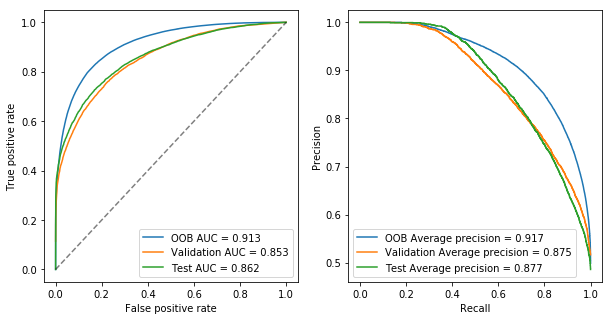

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

fpr, tpr, _ = roc_curve(y_train, y_score_oob)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, label=f'OOB AUC = {roc_auc:.3f}')

precision, recall, _ = precision_recall_curve(y_train, y_score_oob)
pr_score = average_precision_score(y_train, y_score_oob)
ax2.step(recall, precision, label=f'OOB Average precision = {pr_score:.3f}')

fpr, tpr, _ = roc_curve(y_validation, y_score_validation)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, label=f'Validation AUC = {roc_auc:.3f}')

precision, recall, _ = precision_recall_curve(y_validation, y_score_validation)
pr_score = average_precision_score(y_validation, y_score_validation)
ax2.step(recall, precision, label=f'Validation Average precision = {pr_score:.3f}')

fpr, tpr, _ = roc_curve(y_test, y_score_test)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, label=f'Test AUC = {roc_auc:.3f}')

precision, recall, _ = precision_recall_curve(y_test, y_score_test)
pr_score = average_precision_score(y_test, y_score_test)
ax2.step(recall, precision,  label=f'Test Average precision = {pr_score:.3f}')

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.legend()

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend()

Classifier now isn't as good but still exhibits fairly appreciable predictive power.

We have the same issue as before begarding false negatives, with limited false positives.

As expected given how we split this and trained, limited difference between the validation and test set.

0.75987485334376226

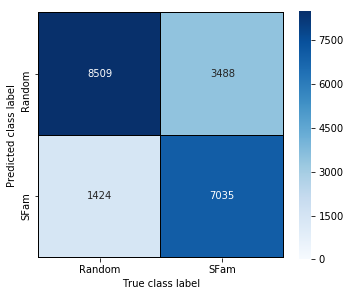

In [23]:
cm = pd.DataFrame(confusion_matrix(y_validation, y_pred_validation)).T
cm.rename({0: 'Random', 1: 'SFam'}, axis='index', inplace=True)
cm.rename({0: 'Random', 1: 'SFam'}, axis='columns', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True, linewidths=0.1, linecolor='k', vmin=0, cbar_kws={'shrink': 0.75}, ax=ax)
ax.set_ylabel('Predicted class label')
ax.set_xlabel('True class label')
fig.tight_layout()
rf.score(X_validation, y_validation)

0.77833583596541189

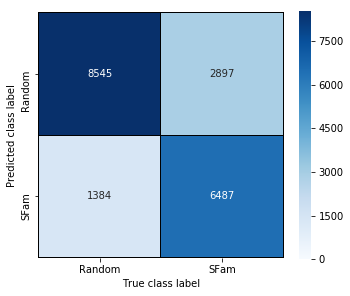

In [24]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred)).T
cm.rename({0: 'Random', 1: 'SFam'}, axis='index', inplace=True)
cm.rename({0: 'Random', 1: 'SFam'}, axis='columns', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True, linewidths=0.1, linecolor='k', vmin=0, cbar_kws={'shrink': 0.75}, ax=ax)
ax.set_ylabel('Predicted class label')
ax.set_xlabel('True class label')
fig.tight_layout()
rf.score(X_test, y_test)

# Grouped k-fold CV using sklearn

In [25]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate

family_data = data[data['Target'].isin(family_targets) & data['Label'].isin(['Fam', 'Random'])]

feature_names = ['Target_Length', 'Template_Length', 'Contact_PPV', 'Contact_TP', 'Contact_P', 'Contact_All', 'Neff', 'SeqID']
np.random.seed(42)
n_samples = 1000
sample = np.random.choice(family_targets, size=n_samples, replace=False)
n_train = int(0.8*n_samples)
n_valid = int(0.1*n_samples)
train = sample[:n_train]
validation = sample[n_train:n_train+n_valid]
test = sample[n_train+n_valid:]

groups = family_data[family_data['Target'].isin(train)]['Target'].values

X_train = family_data[family_data['Target'].isin(train)][feature_names].values
X_validation = family_data[family_data['Target'].isin(validation)][feature_names].values
X_test = family_data[family_data['Target'].isin(test)][feature_names].values

y_train = family_data[family_data['Target'].isin(train)]['Label'].replace({'Random': 0, 'Fam': 1}).values.ravel()
y_validation = family_data[family_data['Target'].isin(validation)]['Label'].replace({'Random': 0, 'Fam': 1}).values.ravel()
y_test = family_data[family_data['Target'].isin(test)]['Label'].replace({'Random': 0, 'Fam': 1}).values.ravel()

In [50]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

#clf = svm.SVC(kernel='linear', C=1, random_state=42)
#clf = RandomForestClassifier(n_estimators=500, max_features='sqrt', random_state=42)
clf = LogisticRegression(C=1e5, random_state=42)

In [57]:
scores = cross_validate(clf, X_train, y_train, scoring='roc_auc', cv=GroupKFold(n_splits=3).split(X_train, y_train, groups), return_train_score=False, n_jobs=-1)
print("LR unscaled: ", scores['test_score'])

LR unscaled:  [ 0.90122184  0.91290733  0.85685427]


In [58]:
from sklearn.preprocessing import MinMaxScaler
X_train_scaled = MinMaxScaler().fit_transform(X_train)
scores = cross_validate(clf, X_train_scaled, y_train, scoring='roc_auc', cv=GroupKFold(n_splits=3).split(X_train_scaled, y_train, groups), return_train_score=False, n_jobs=-1)
print("LR scaled: ", scores['test_score'])

LR scaled:  [ 0.92293701  0.91758914  0.90138679]


In [59]:
clf = RandomForestClassifier(n_estimators=500, max_features='sqrt', random_state=42)
scores = cross_validate(clf, X_train, y_train, scoring='roc_auc', cv=GroupKFold(n_splits=3).split(X_train, y_train, groups), return_train_score=False, n_jobs=-1)
print("RF unscaled: ", scores['test_score'])

RF unscaled:  [ 0.93008719  0.93010402  0.91690146]


In [ ]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)
scores = cross_validate(clf, X_train_scaled, y_train, scoring='roc_auc', cv=GroupKFold(n_splits=3).split(X_train_scaled, y_train, groups), return_train_score=False, n_jobs=-1)
print("LR scaled: ", scores['test_score'])